# Plot K-shot learning figures

In [40]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib


In [41]:
results_dir = "/home/hossein/ssl-wearables/data/reports/notable_results_Kshot_MLPv5.csv"
selected_model = "MLP" #"RESNET" # "MLP"
results = pd.read_csv(results_dir)
results = results[results["model"]==selected_model]
results = results.sort_values(by=["plot_legend", "split"])
print(results.columns)
print(results["plot_legend"].unique())   

Index(['path', 'trained_dataset', 'evaluated_dataset', 'train_map_path',
       'validation', 'split', 'plot_legend', 'conditions', 'comments',
       'freeze_weight', 'model'],
      dtype='object')
['Broader -> OPT' 'Broader -> OPT -> Personalized'
 'Broader -> Personalized' 'OPT -> Personalized' 'Personalized']


In [42]:
def aggregate_metrics(df, metrics):
    """
    Aggregate the metrics by calculating the mean and standard deviation of the given metric.
    """
    results = pd.DataFrame()
    for metric in metrics:
        # print(f"Aggregating metric: {metric}")
        df1=aggregate_metric(df, metric)
        df1.reset_index(drop=True, inplace=True)
        # print(df1)
        #concatenate the new DataFrame with the original DataFrame
        results = pd.concat([results, df1], axis=1)
        # results = results.join(df1)
        # print(results)
        # df = df.join(aggregate_metric(df, metric))
    # print(results)
    return results
def aggregate_metric(df, metric):
    """
    Aggregate a single metric by calculating the mean and standard deviation.
    """
    # Check if the metric exists in the DataFrame
    if metric not in df.columns:
        raise ValueError(f"Metric '{metric}' not found in DataFrame columns.")
    # Group by conditions and split, and calculate mean and std
    # for the given metric
    result = df[metric].agg(['mean', 'std']).to_frame().T
    result.columns = [f'{metric}_mean', f'{metric}_std']
    return result


In [43]:
import re

def aggregate_results(df_r, mertics, results_dir):
    """
    Aggregate the results by calculating the mean and standard deviation of the given metrics.
    """
    # Create an empty DataFrame to store the aggregated results
    metric_agg_df = pd.DataFrame()
    # Iterate through each condition in the DataFrame
    for condition in df_r["plot_legend"].unique():
        print(condition)
        # Get the paths and splits for the current condition
        paths = df_r[df_r["plot_legend"] == condition][["path","split"]].values
        # Iterate through each path and split
        for path,split in paths:
            full_path = os.path.join(results_dir, path)
            # Find the longest file name with csv extension
            result_file = max((file for file in os.listdir(full_path) if file.endswith(".csv")), key=len, default="")
            print(split,":", os.path.join(full_path,result_file))
            # Read the csv file
            df = pd.read_csv(os.path.join(full_path,result_file))
            df_agg = aggregate_metrics(df, mertics)
            # print(df_agg)
            df_agg["plot_legend"] = condition
            df_agg["split"] = split
            # Extract numbers from the split string using regex
            shot_number = re.search(r'\d+', split)
            df_agg["shot_number"] = int(shot_number.group()) if shot_number else None
            # df_agg["shot"] = split
            df_agg["path"] = path
            df_agg.reset_index(drop=True, inplace=True)
            metric_agg_df = pd.concat([metric_agg_df, df_agg], axis=0)
    return metric_agg_df

metric_agg_df = aggregate_results(results, ["f1_weighted", "f1"], "/home/hossein/ssl-wearables/data/reports")
# sort the DataFrame by 'plot_legend' and 'shot_number'
metric_agg_df = metric_agg_df.sort_values(by=["plot_legend", "shot_number"])
#filter shot_number (5,20,50)
metric_agg_df = metric_agg_df[metric_agg_df["shot_number"].isin([5, 20, 50])]
# Reset the index
metric_agg_df.reset_index(drop=True, inplace=True)

    

Broader -> OPT
LOSO 20-shot : /home/hossein/ssl-wearables/data/reports/2025-05-14_21-19/mymove_10s_5c_v2_mlp_-1.csv
LOSO 5-shot : /home/hossein/ssl-wearables/data/reports/2025-05-14_21-16/mymove_10s_5c_v2_mlp_-1.csv
LOSO 50-shot : /home/hossein/ssl-wearables/data/reports/2025-05-14_21-30/mymove_10s_5c_v2_mlp_-1.csv
Broader -> OPT -> Personalized
20-shot : /home/hossein/ssl-wearables/data/reports/2025-05-15_00-41/mymove_10s_5c_v2_mlp_-1.csv
5-shot : /home/hossein/ssl-wearables/data/reports/2025-05-15_00-38/mymove_10s_5c_v2_mlp_-1.csv
50-shot : /home/hossein/ssl-wearables/data/reports/2025-05-15_00-44/mymove_10s_5c_v2_mlp_-1.csv
Broader -> Personalized
20-shot : /home/hossein/ssl-wearables/data/reports/2025-05-15_00-31/mymove_10s_5c_v2_mlp_-1.csv
5-shot : /home/hossein/ssl-wearables/data/reports/2025-05-14_21-33/mymove_10s_5c_v2_mlp_-1.csv
50-shot : /home/hossein/ssl-wearables/data/reports/2025-05-15_00-35/mymove_10s_5c_v2_mlp_-1.csv
OPT -> Personalized
20-shot : /home/hossein/ssl-wearab

## plot metric across K-shots for different conditions

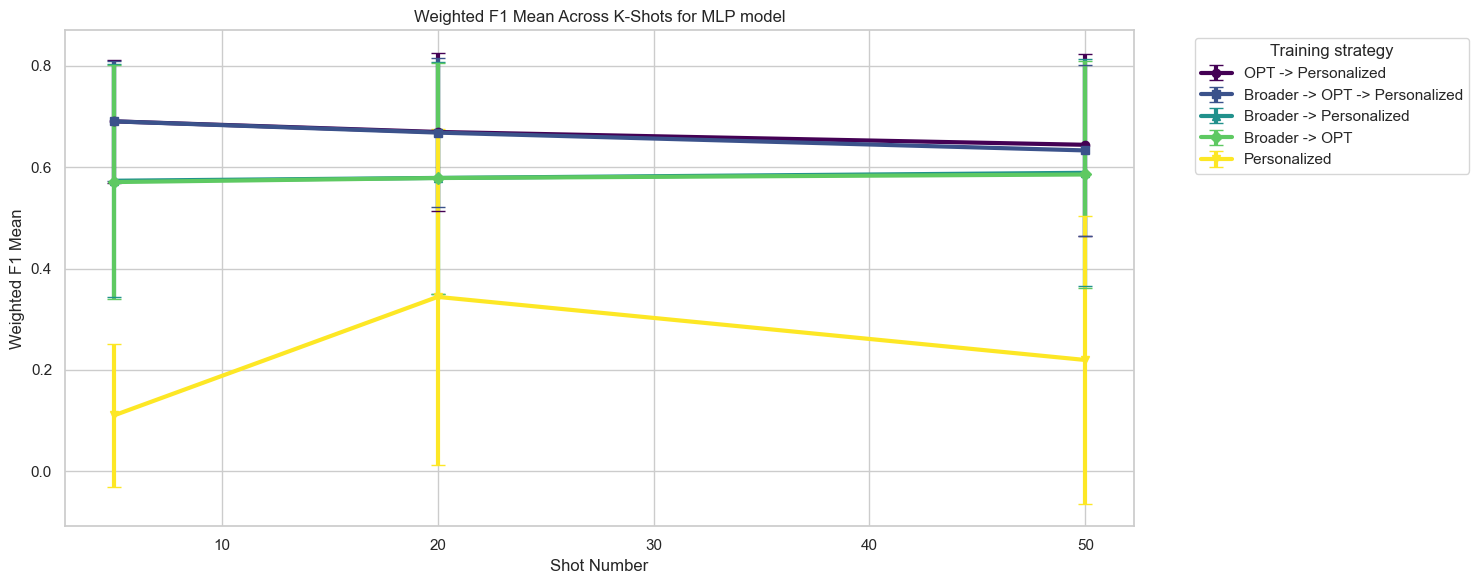

In [44]:
# Import the colormap
from matplotlib.cm import viridis
from matplotlib.colors import Normalize

# Filter unique conditions
conditions = metric_agg_df['plot_legend'].unique()
conditions = metric_agg_df[metric_agg_df['shot_number'] == metric_agg_df['shot_number'].max()].sort_values('f1_weighted_mean', ascending=False)['plot_legend'].tolist()

# Create a figure
plt.figure(figsize=(15, 6))

# Normalize the number of conditions for the colormap
norm = Normalize(vmin=0, vmax=len(conditions) - 1)
markers = ['o', 's', '^', 'D', 'v', 'x']
# Loop through each condition and plot the data
for idx, condition in enumerate(conditions):
    condition_data = metric_agg_df[metric_agg_df['plot_legend'] == condition]
    plt.errorbar(
        condition_data['shot_number'], 
        condition_data['f1_weighted_mean'], 
        yerr=condition_data['f1_weighted_std'], 
        label=condition, 
        capsize=5, 
        marker=markers[idx % len(markers)], 
        color=viridis(norm(idx)),
        linewidth=3
    )

# Add labels, title, and legend
plt.xlabel('Shot Number')
plt.ylabel('Weighted F1 Mean')
plt.title(f"Weighted F1 Mean Across K-Shots for {selected_model} model")
plt.legend(title='Training strategy', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

                      plot_legend
0             OPT -> Personalized
1  Broader -> OPT -> Personalized
2         Broader -> Personalized
3                  Broader -> OPT
4                    Personalized


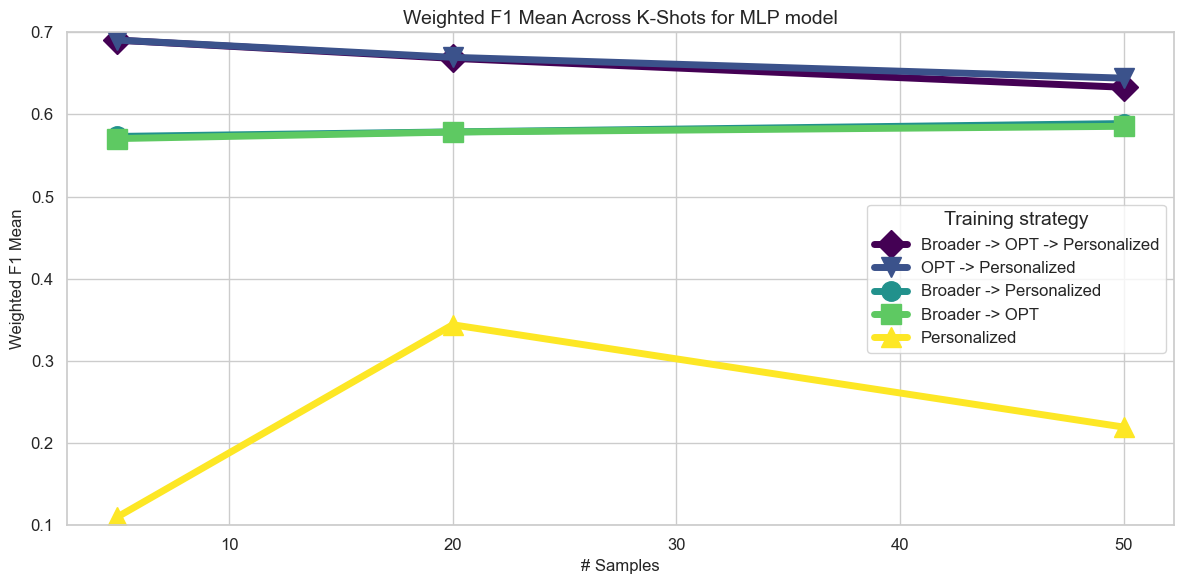

In [45]:
import matplotlib.pyplot as plt
from matplotlib.cm import viridis
from matplotlib.colors import Normalize

# Filter unique conditions
conditions = metric_agg_df['plot_legend'].unique()
#sort conditions based on the f1_weighted_mean of the last shot
print(metric_agg_df[metric_agg_df['shot_number'] == metric_agg_df['shot_number'].max()].sort_values('f1_weighted_mean', ascending=False)[['plot_legend']].reset_index(drop=True))
conditions = metric_agg_df[metric_agg_df['shot_number'] == metric_agg_df['shot_number'].max()].sort_values('f1_weighted_mean', ascending=False)['plot_legend'].tolist()
# Manually set the order for conditions
order_dict = {
    'Broader -> OPT -> Personalized': 1,
    'OPT -> Personalized': 2,
    'Broader -> Personalized': 3,
    'Broader -> OPT': 4,
    'Personalized': 5,
    'Personalized (No SSL)': 6,
}

# Sort conditions based on the manual order
conditions = sorted(conditions, key=lambda cond: order_dict.get(cond, float('inf')))
plt.figure(figsize=(12, 6))

# Normalize for color mapping
norm = Normalize(vmin=0, vmax=len(conditions) - 1)
markers = ['D', 'v', 'o', 's', '^','x']

# Plot each condition
for idx, condition in enumerate(conditions):
    condition_data = metric_agg_df[metric_agg_df['plot_legend'] == condition]
    x = condition_data['shot_number']
    y = condition_data['f1_weighted_mean']
    std = condition_data['f1_weighted_std']
    color = viridis(norm(idx))

    # Main line
    plt.plot(
        x, y,
        marker=markers[idx % len(markers)],
        markersize=14,
        label=condition,
        color=color,
        linewidth=5
    )
    

    # # Shaded area
    # plt.fill_between(
    #     x,
    #     y - std,
    #     y + std,
    #     color=color,
    #     alpha=0.3
    # )

# Labels, title, legend, and layout
plt.xticks(ticks=list(range(10,60,10)), labels=list(range(10,60,10)))
plt.xlabel('# Samples',fontsize=12)
plt.ylabel('Weighted F1 Mean', fontsize=12)
plt.ylim(0.1, 0.7)
plt.title(f"Weighted F1 Mean Across K-Shots for {selected_model} model", fontsize=14)
plt.legend(title='Training strategy', loc='right',fontsize=12, title_fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [46]:
import re
def individual_results(df_r, metric, results_dir):
    """
    Aggregate the results by calculating the mean and standard deviation of the given metrics.
    """
    print("Aggregating results...")
    # Create an empty DataFrame to store the aggregated results
    df_all_individual = pd.DataFrame()
    for condition in df_r["plot_legend"].unique():
        print(condition)
        # Get the paths and splits for the current condition
        paths = df_r[df_r["plot_legend"] == condition][["path","split"]].values
        # Iterate through each path and split
        for path,split in paths:
            full_path = os.path.join(results_dir, path)
            # Find the longest file name with csv extension
            result_file = max((file for file in os.listdir(full_path) if file.endswith(".csv")), key=len, default="")
            print(split,":", os.path.join(full_path,result_file))
            # Read the csv file
            df = pd.read_csv(os.path.join(full_path,result_file))
            print(df.columns)
            df_individual = df[[metric]].copy()
            fold_participant = pd.Series([f'P{i}' for i in range(1, 14)], index=df_individual.index)
            fold_participant = fold_participant.sort_values().reset_index(drop=True)

            df_individual["fold"] = fold_participant
            
            df_individual["plot_legend"] = condition
            df_individual["split"] = split
            # Extract numbers from the split string using regex
            shot_number = re.search(r'\d+', split)
            df_individual["shot_number"] = int(shot_number.group()) if shot_number else None
            # df_agg["shot"] = split
            df_individual["path"] = path
            df_individual.reset_index(drop=True, inplace=True)
            df_all_individual = pd.concat([df_all_individual, df_individual], axis=0)
    return df_all_individual
df_all_individual = individual_results(results, 'f1_weighted', "/home/hossein/ssl-wearables/data/reports")
df_all_individual = df_all_individual[df_all_individual["shot_number"].isin([5, 20, 50])]


Aggregating results...
Broader -> OPT
LOSO 20-shot : /home/hossein/ssl-wearables/data/reports/2025-05-14_21-19/mymove_10s_5c_v2_mlp_-1.csv
Index(['cohen_kappa', 'precision', 'recall', 'f1', 'f1_weighted',
       'confusion_matrix', 'auc'],
      dtype='object')
LOSO 5-shot : /home/hossein/ssl-wearables/data/reports/2025-05-14_21-16/mymove_10s_5c_v2_mlp_-1.csv
Index(['cohen_kappa', 'precision', 'recall', 'f1', 'f1_weighted',
       'confusion_matrix', 'auc'],
      dtype='object')
LOSO 50-shot : /home/hossein/ssl-wearables/data/reports/2025-05-14_21-30/mymove_10s_5c_v2_mlp_-1.csv
Index(['cohen_kappa', 'precision', 'recall', 'f1', 'f1_weighted',
       'confusion_matrix', 'auc'],
      dtype='object')
Broader -> OPT -> Personalized
20-shot : /home/hossein/ssl-wearables/data/reports/2025-05-15_00-41/mymove_10s_5c_v2_mlp_-1.csv
Index(['cohen_kappa', 'precision', 'recall', 'f1', 'f1_weighted',
       'confusion_matrix', 'auc'],
      dtype='object')
5-shot : /home/hossein/ssl-wearables/data

Plotting individual results...


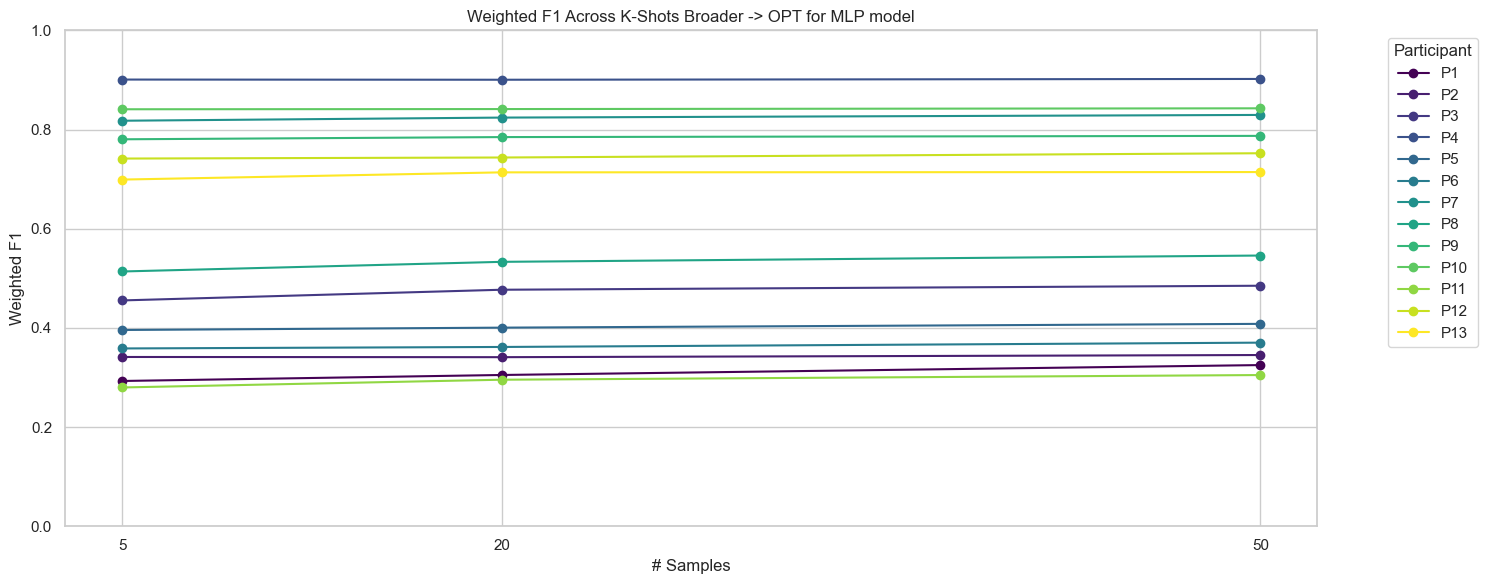

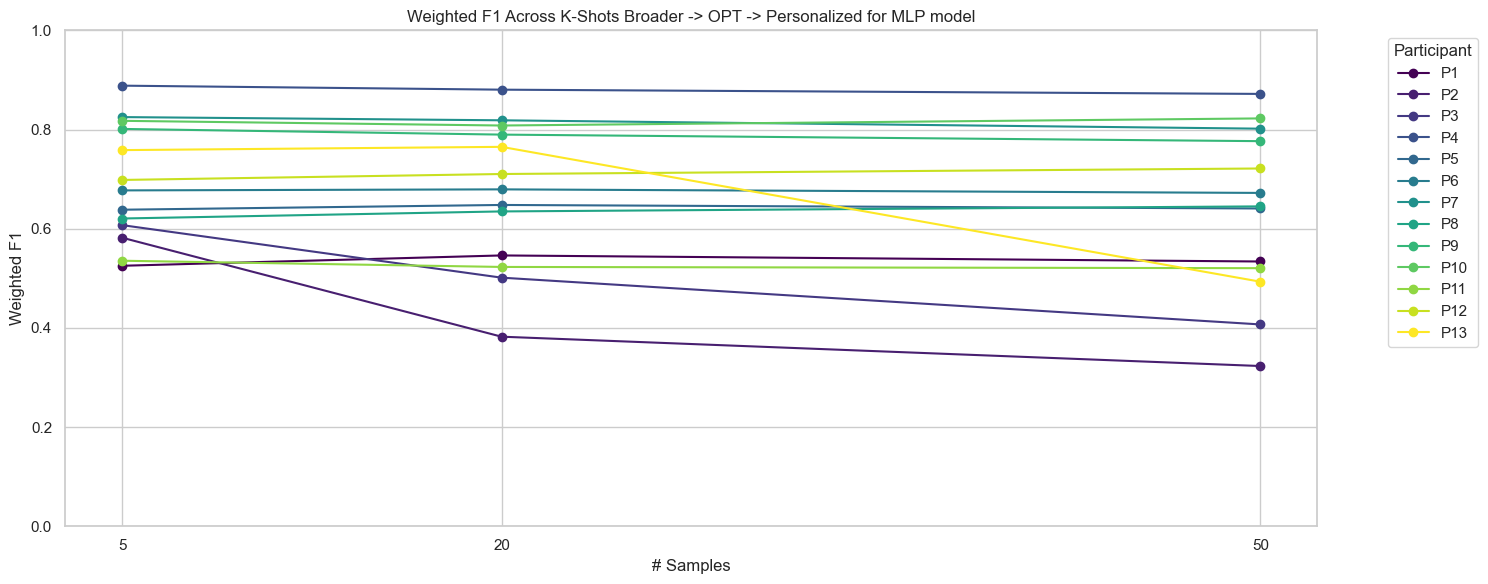

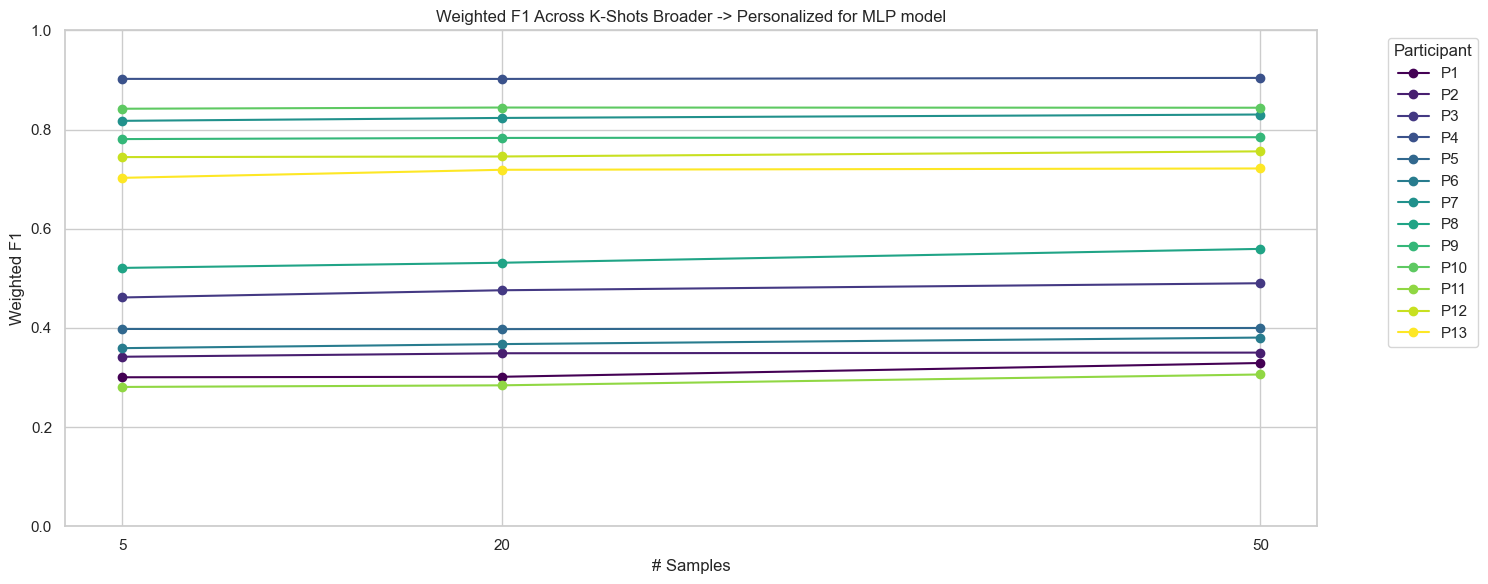

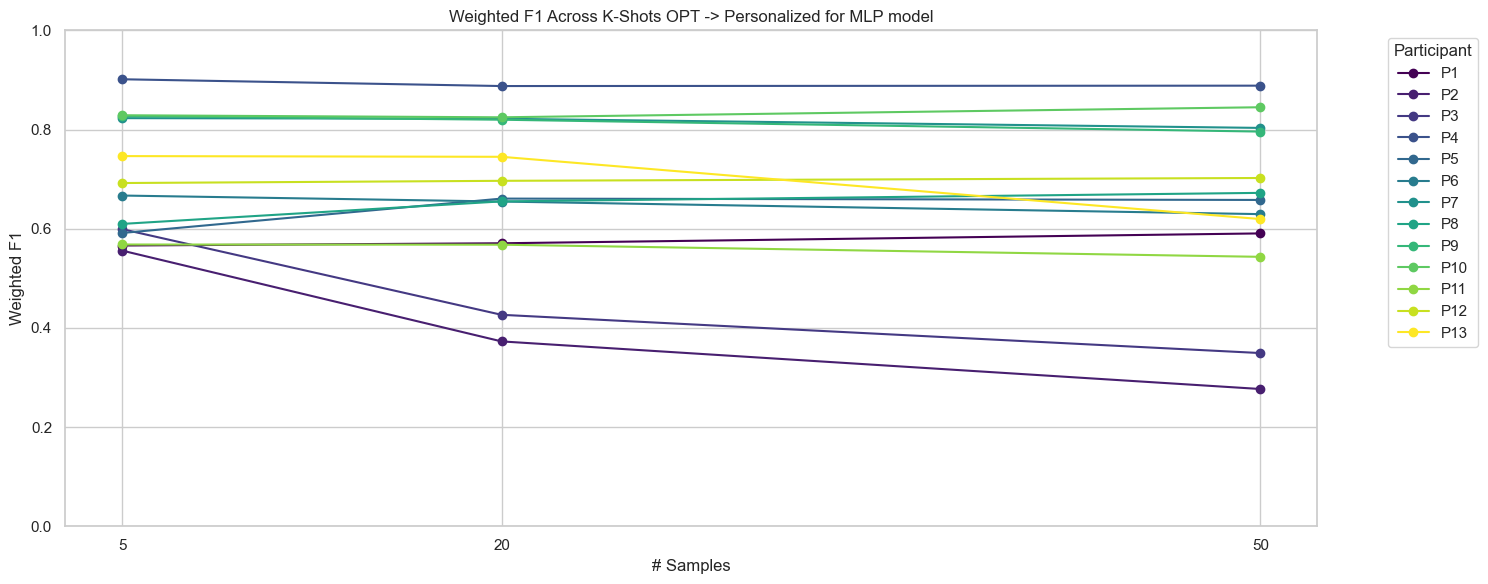

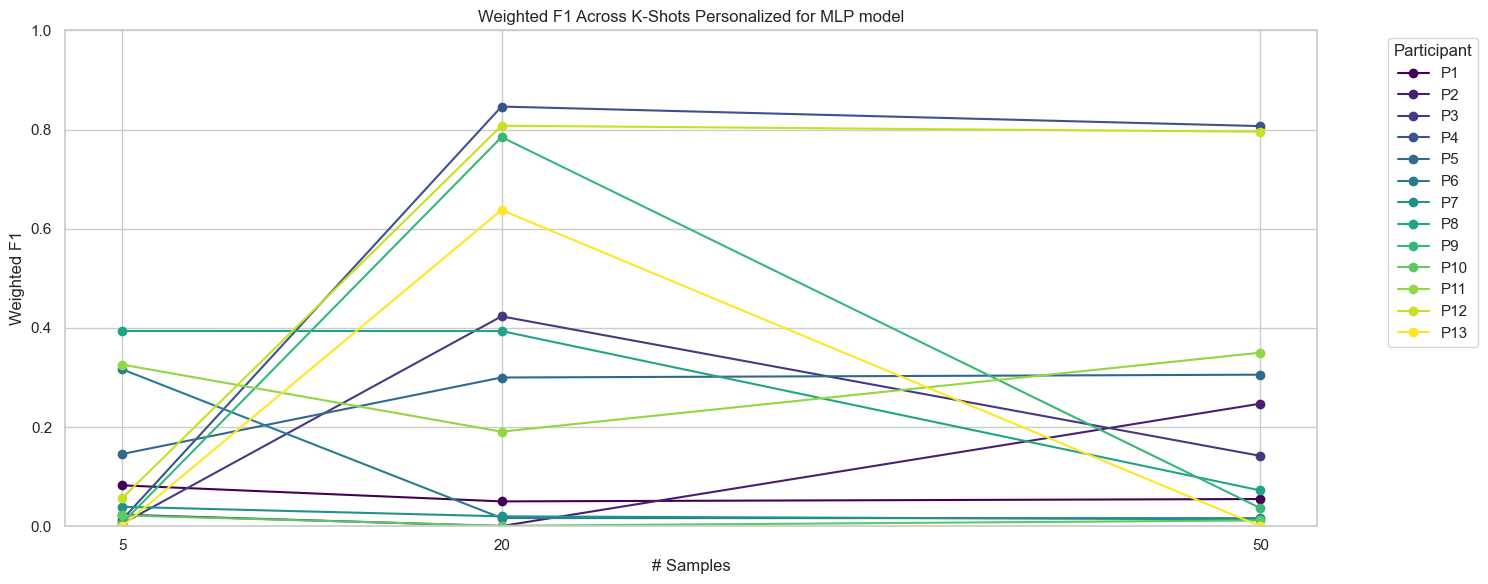

In [47]:
import matplotlib.pyplot as plt
import numpy as np

def plot_individual_results(df, metric):
    """
    Plot the individual results for each condition using the viridis colormap.
    """
    print("Plotting individual results...")

    conditions = df['plot_legend'].unique()
    
    for condition in conditions:
        plt.figure(figsize=(15, 6))
        condition_data = df[df['plot_legend'] == condition]

        # Sort folds numerically based on the number after 'P'
        unique_folds = sorted(
            condition_data['fold'].unique(),
            key=lambda x: int(x.replace('P', ''))
        )

        num_folds = len(unique_folds)
        colors = plt.cm.viridis(np.linspace(0, 1, num_folds))

        for i, fold in enumerate(unique_folds):
            fold_data = condition_data[condition_data['fold'] == fold]
            fold_data = fold_data.sort_values('shot_number')
            plt.plot(
                fold_data['shot_number'], 
                fold_data[metric], 
                label=f"{fold}", 
                marker='o',
                color=colors[i]
            )
        ticks = fold_data['shot_number'].unique().tolist()
        ticks = sorted(ticks)
        
        plt.xlabel('# Samples')
        plt.ylabel('Weighted F1')
        plt.title(f'Weighted F1 Across K-Shots {condition} for {selected_model} model')
        plt.ylim(0, 1)
        plt.xticks(ticks=ticks)
        plt.legend(title='Participant', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, which='major', axis='x')
        plt.xticks(ticks=ticks)
        plt.tight_layout()
        plt.show()

# Call the function
plot_individual_results(df_all_individual, 'f1_weighted')

Plotting individual results...


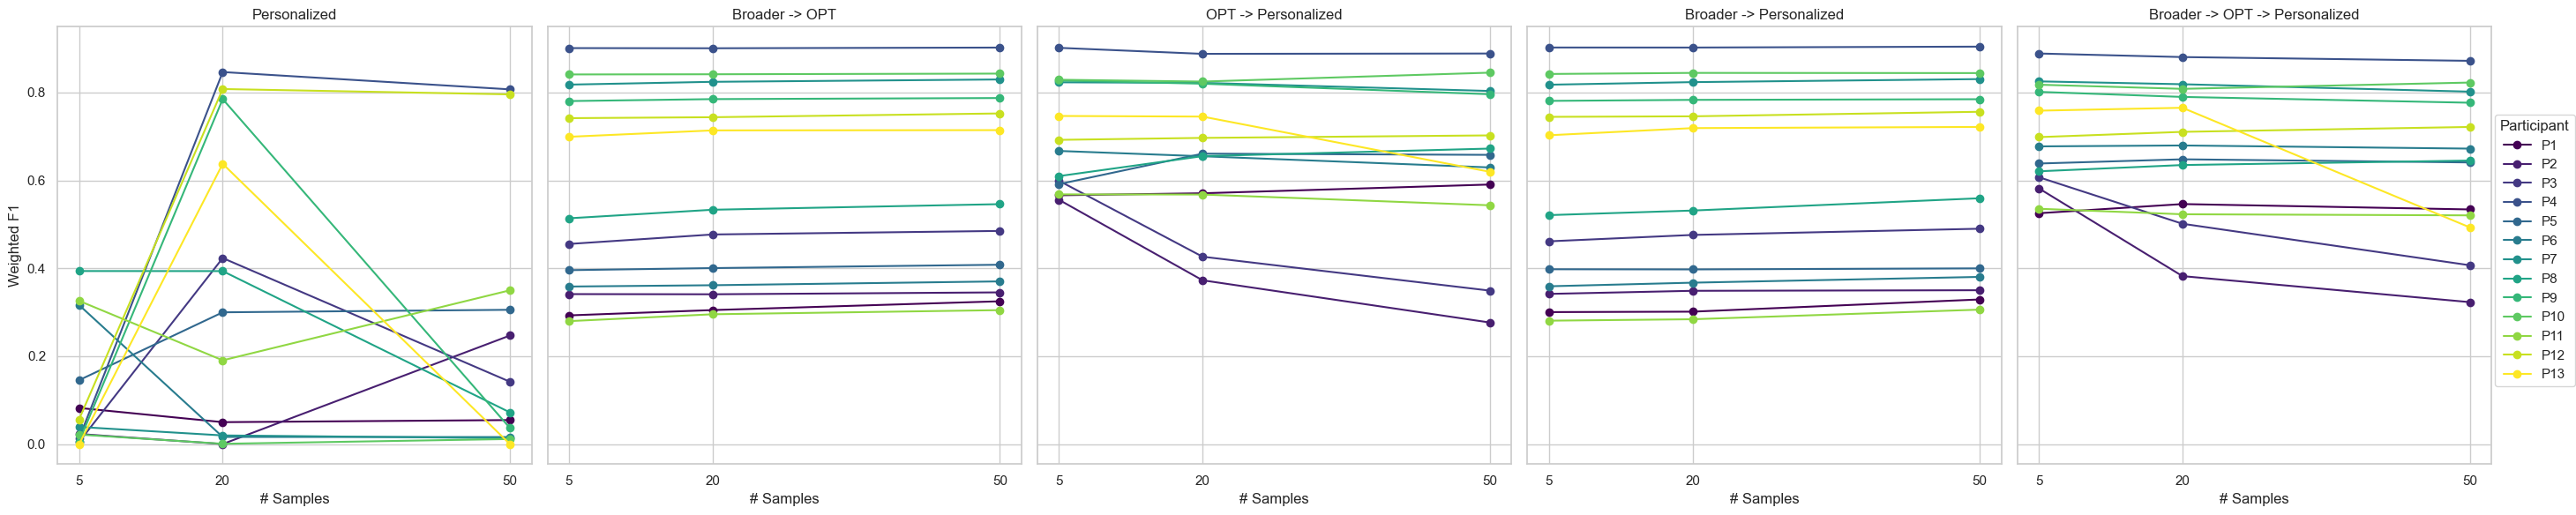

In [48]:
import matplotlib.pyplot as plt
import numpy as np

def plot_individual_results(df, metric):
    """
    Plot the individual results for each condition using the viridis colormap
    with subplots arranged side by side.
    """
    print("Plotting individual results...")

    conditions = df['plot_legend'].unique()
    num_conditions = len(conditions)
    conditions = sorted(conditions, key=len)
    # Create subplots
    fig, axes = plt.subplots(1, num_conditions, figsize=(6 * num_conditions, 6), sharey=True)

    # If only 1 condition, axes won't be an array
    if num_conditions == 1:
        axes = [axes]

    for ax, condition in zip(axes, conditions):
        condition_data = df[df['plot_legend'] == condition]

        # Sort folds numerically
        unique_folds = sorted(
            condition_data['fold'].unique(),
            key=lambda x: int(x.replace('P', ''))
        )

        num_folds = len(unique_folds)
        colors = plt.cm.viridis(np.linspace(0, 1, num_folds))

        for i, fold in enumerate(unique_folds):
            fold_data = condition_data[condition_data['fold'] == fold]
            fold_data = fold_data.sort_values('shot_number')
            ax.plot(
                fold_data['shot_number'], 
                fold_data[metric], 
                label=f"{fold}", 
                marker='o',
                color=colors[i]
            )

        ax.set_xlabel('# Samples')
        ax.set_title(f'{condition}')
        ax.grid(True, which='major', axis='x')
        ticks = fold_data['shot_number'].unique().tolist()
        ticks = sorted(ticks)
        ax.set_xticks(ticks)
        # ax.set_xticks([10, 20, 30, 40, 50])

    # Shared y-axis label
    axes[0].set_ylabel('Weighted F1')

    # Place one shared legend outside the plot
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, title='Participant', bbox_to_anchor=(0.94, 0.5), loc='center left')

    plt.tight_layout(rect=[0, 0, 0.95, 1])  # leave space for legend
    plt.show()

# Call the function
plot_individual_results(df_all_individual, 'f1_weighted')

Plotting individual results...


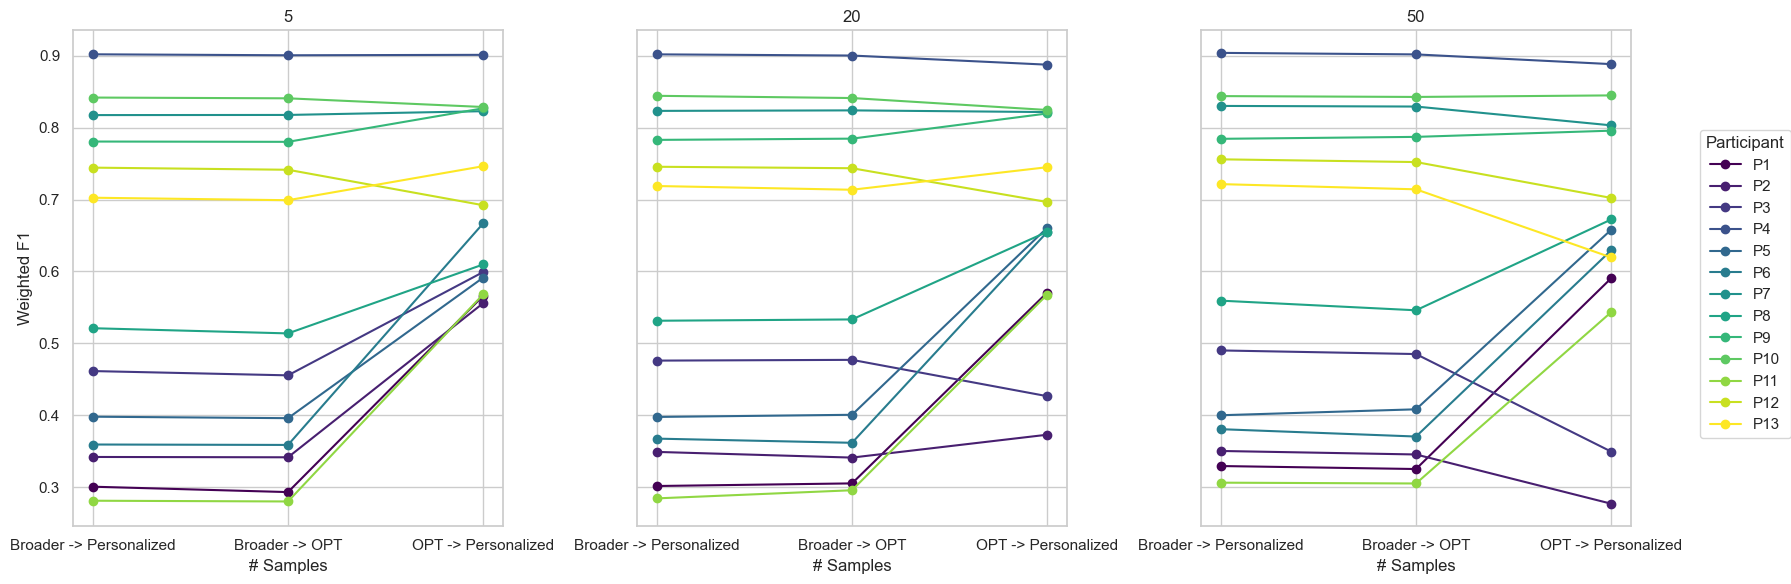

In [49]:
import matplotlib.pyplot as plt
import numpy as np

def plot_individual_results(df, metric):
    """
    Plot the individual results for each condition using the viridis colormap
    with subplots arranged side by side.
    """
    print("Plotting individual results...")

    conditions = df['plot_legend'].unique()
    num_conditions = len(conditions)
    conditions = sorted(conditions, key=len)
    conditions = ['Broader -> Personalized','Broader -> OPT', 'OPT -> Personalized']
    df = df[df['plot_legend'].isin(conditions)]
    df = df[df['plot_legend'] != 'Broader -> OPT -> Personalized']
    # sort the dataframe by conditions
    # Define the custom order for plot_legend
    custom_order = ['Broader -> Personalized', 'Broader -> OPT', 'OPT -> Personalized']

    # Convert the plot_legend column to a categorical type with the custom order
    df['plot_legend'] = pd.Categorical(df['plot_legend'], categories=custom_order, ordered=True)

    # Sort the DataFrame by the plot_legend column
    df = df.sort_values(by='plot_legend')
    shut_numbers = df['shot_number'].unique()
    shut_numbers = sorted(shut_numbers, key=lambda x: int(x))
    # Create subplots
    fig, axes = plt.subplots(1, len(shut_numbers), figsize=(6 * len(shut_numbers), 6), sharey=True)

    # If only 1 condition, axes won't be an array
    if num_conditions == 1:
        axes = [axes]

    for ax, shot_number in zip(axes, shut_numbers):
        shot_number_data = df[df['shot_number'] == shot_number]
        # condition_data = df[df['plot_legend'] == condition]

        # Sort folds numerically
        unique_folds = sorted(
            shot_number_data['fold'].unique(),
            key=lambda x: int(x.replace('P', ''))
        )

        num_folds = len(unique_folds)
        colors = plt.cm.viridis(np.linspace(0, 1, num_folds))

        for i, fold in enumerate(unique_folds):
            fold_data = shot_number_data[shot_number_data['fold'] == fold]
            fold_data = fold_data.sort_values('shot_number')
            ax.plot(
                fold_data['plot_legend'], 
                fold_data[metric], 
                label=f"{fold}", 
                marker='o',
                color=colors[i]
            )

        ax.set_xlabel('# Samples')
        ax.set_title(f'{shot_number}')
        ax.grid(True, which='major', axis='x')
        ticks = fold_data['plot_legend'].unique().tolist()
        ticks = sorted(ticks)
        ax.set_xticks(ticks)
        # ax.set_xticks([10, 20, 30, 40, 50])

    # Shared y-axis label
    axes[0].set_ylabel('Weighted F1')

    # Place one shared legend outside the plot
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, title='Participant', bbox_to_anchor=(0.94, 0.5), loc='center left')

    plt.tight_layout(rect=[0, 0, 0.95, 1])  # leave space for legend
    plt.show()

# Call the function
plot_individual_results(df_all_individual, 'f1_weighted')

In [50]:
import pandas as pd

def compare_conditions(df, metric, shot_number=50):
    """
    Compare metric values for two conditions at a specific shot number.
    Outputs a LaTeX table with bolded positive changes.
    """
    print(f"Comparing {metric} at Shot Number {shot_number}...")

    target_conditions = ['Broader -> OPT', 'Broader -> OPT -> Personalized']

    # Filter to shot_number and relevant conditions
    filtered_df = df[
        (df['shot_number'] == shot_number) &
        (df['plot_legend'].isin(target_conditions))
    ]

    # Pivot table: index=fold, columns=condition, values=metric
    pivot = filtered_df.pivot(index='fold', columns='plot_legend', values=metric)

    # Drop incomplete rows
    pivot = pivot.dropna()

    # Compute the change
    pivot['Change'] = pivot['Broader -> OPT -> Personalized'] - pivot['Broader -> OPT']

    # Sort participants numerically
    pivot = pivot.reindex(
        sorted(pivot.index, key=lambda x: int(x.replace('P', '')))
    )

    # Build table with LaTeX bold formatting for positive changes
    table_rows = []
    for fold in pivot.index:
        opt_value = pivot.loc[fold, 'Broader -> OPT']
        personalized_value = pivot.loc[fold, 'Broader -> OPT -> Personalized']
        change = pivot.loc[fold, 'Change']

        # Bold positive changes
        change_str = f"\\textbf{{{change:.3f}}}" if change > 0 else f"{change:.3f}"

        table_rows.append({
            'Participant': fold,
            'Broader -> OPT': f"{opt_value:.3f}",
            'Broader -> OPT -> Personalized': f"{personalized_value:.3f}",
            'Change': change_str
        })

    result_table = pd.DataFrame(table_rows)

    # Generate LaTeX table
    latex_table = result_table.to_latex(index=False, escape=False)
    print(latex_table)

# Example call
compare_conditions(df_all_individual, 'f1_weighted', shot_number=50)

Comparing f1_weighted at Shot Number 50...
\begin{tabular}{llll}
\toprule
Participant & Broader -> OPT & Broader -> OPT -> Personalized &         Change \\
\midrule
         P1 &          0.325 &                          0.534 & \textbf{0.209} \\
         P2 &          0.345 &                          0.323 &         -0.022 \\
         P3 &          0.485 &                          0.407 &         -0.078 \\
         P4 &          0.902 &                          0.872 &         -0.030 \\
         P5 &          0.408 &                          0.641 & \textbf{0.233} \\
         P6 &          0.370 &                          0.672 & \textbf{0.302} \\
         P7 &          0.830 &                          0.802 &         -0.028 \\
         P8 &          0.546 &                          0.645 & \textbf{0.099} \\
         P9 &          0.787 &                          0.777 &         -0.011 \\
        P10 &          0.843 &                          0.823 &         -0.020 \\
        P11 &  

Comparing f1_weighted at Shot Number 50...
|    | Participant   |   Broader -> OPT |   Broader -> OPT -> Personalized | Change    |
|----|---------------|------------------|----------------------------------|-----------|
|  0 | P1            |            0.505 |                            0.42  | -0.084    |
|  1 | P2            |            0.421 |                            0.396 | -0.024    |
|  2 | P3            |            0.39  |                            0.462 | **0.072** |
|  3 | P4            |            0.519 |                            0.704 | **0.185** |
|  4 | P5            |            0.514 |                            0.615 | **0.101** |
|  5 | P6            |            0.394 |                            0.603 | **0.209** |
|  6 | P7            |            0.657 |                            0.725 | **0.069** |
|  7 | P8            |            0.432 |                            0.297 | -0.135    |
|  8 | P9            |            0.505 |                            0.64  | **0.135** |
|  9 | P10           |            0.354 |                            0.697 | **0.343** |
| 10 | P11           |            0.454 |                            0.414 | -0.040    |
| 11 | P12           |            0.678 |                            0.414 | -0.264    |
| 12 | P13           |            0.173 |                            0.563 | **0.391** |

### Check validation and training loss at each step (epoch)

In [51]:
import os
import numpy as np
import matplotlib.pyplot as plt

def plot_validation_loss(df, results_dir):
    """
    Plot the validation loss and accuracy from the .npz files.
    
    Parameters:
    df (DataFrame): DataFrame containing the paths to the .npz files.
    results_dir (str): Directory where the .npz files are located.
    """
    
    # Set the style for seaborn
    sns.set_theme(style="whitegrid")
    
    # Create a directory to save the plots if it doesn't exist
    os.makedirs(results_dir, exist_ok=True)
    
    # Loop over the 'path' column in the DataFrame
    for path in df['path']:
        full_path = os.path.join(results_dir, path, "train_log.npz")
        
        # Check if the file exists
        if os.path.exists(full_path):
            # Load the data from the .npz file
            data = np.load(full_path)
            
            # Extract the required metrics
            valid_loss = data['val_loss']
            train_loss = data['train_loss']
            valid_acc = data['val_acc']
            train_acc = data['train_acc']
            
            # Create subplots
            fig, axes = plt.subplots(1, 2, figsize=(12, 6))
            
            # Plot valid_loss and train_loss in subplot 1
            axes[0].plot(valid_loss, label='Valid Loss', color='blue')
            axes[0].plot(train_loss, label='Train Loss', color='orange')
            axes[0].set_title('Loss')
            axes[0].set_xlabel('Epoch')
            axes[0].set_ylabel('Loss')
            axes[0].legend()
            axes[0].grid(True)
            
            # Plot valid_acc and train_acc in subplot 2
            axes[1].plot(valid_acc, label='Valid Accuracy', color='green')
            axes[1].plot(train_acc, label='Train Accuracy', color='red')
            axes[1].set_title('Accuracy')
            axes[1].set_xlabel('Epoch')
            axes[1].set_ylabel('Accuracy')
            axes[1].legend()
            axes[1].grid(True)
            
            # Adjust layout
            plt.tight_layout()
            
            # Save the plot in the same directory
            save_path = os.path.join(results_dir, path, "training_metrics.png")
            plt.savefig(save_path)
            plt.close(fig)  # Close the figure to free memory
        else:
            print(f"File 'train_log.npz' not found in {full_path}")
# Call the function to plot validation loss and accuracy
plot_validation_loss(results, "/home/hossein/ssl-wearables/data/reports")

File 'train_log.npz' not found in /home/hossein/ssl-wearables/data/reports/2025-05-14_21-19/train_log.npz
File 'train_log.npz' not found in /home/hossein/ssl-wearables/data/reports/2025-05-14_21-16/train_log.npz
File 'train_log.npz' not found in /home/hossein/ssl-wearables/data/reports/2025-05-14_21-30/train_log.npz
File 'train_log.npz' not found in /home/hossein/ssl-wearables/data/reports/2025-05-15_00-41/train_log.npz
File 'train_log.npz' not found in /home/hossein/ssl-wearables/data/reports/2025-05-15_00-38/train_log.npz
File 'train_log.npz' not found in /home/hossein/ssl-wearables/data/reports/2025-05-15_00-44/train_log.npz
File 'train_log.npz' not found in /home/hossein/ssl-wearables/data/reports/2025-05-15_00-31/train_log.npz
File 'train_log.npz' not found in /home/hossein/ssl-wearables/data/reports/2025-05-14_21-33/train_log.npz
File 'train_log.npz' not found in /home/hossein/ssl-wearables/data/reports/2025-05-15_00-35/train_log.npz
File 'train_log.npz' not found in /home/hossei

In [52]:

results_dir = "/home/hossein/ssl-wearables/data/reports"
path = "2025-05-06_19-39"
full_path = os.path.join(results_dir, path, "train_log.npz")

if os.path.exists(full_path):
    # Load the data from the .npz file
    all_data = np.load(full_path, allow_pickle=True)

    num_keys = len(all_data.keys())
    fig, axes = plt.subplots(num_keys, 2, figsize=(12, 4 * num_keys), squeeze=False)

    for i, key in enumerate(all_data.keys()):
        data = all_data[key].item()

        # Extract the required metrics
        valid_loss = data['val_loss']
        train_loss = data['train_loss']
        valid_acc = data['val_acc']
        train_acc = data['train_acc']
        # Plot Loss
        axes[i, 0].plot(valid_loss, label='Valid Loss', color='blue')
        axes[i, 0].plot(train_loss, label='Train Loss', color='orange')
        axes[i, 0].set_title(f'{key} - Loss')
        axes[i, 0].set_xlabel('Epoch')
        axes[i, 0].set_ylabel('Loss')
        axes[i, 0].set_ylim(0, 10)  # Set y-axis range
        axes[i, 0].legend()
        axes[i, 0].grid(True)

        # Plot Accuracy
        axes[i, 1].plot(valid_acc, label='Valid Accuracy', color='green')
        axes[i, 1].plot(train_acc, label='Train Accuracy', color='red')
        axes[i, 1].set_title(f'{key} - Accuracy')
        axes[i, 1].set_xlabel('Epoch')
        axes[i, 1].set_ylabel('Accuracy')
        axes[i, 1].set_ylim(0, 1)
        axes[i, 1].legend()
        axes[i, 1].grid(True)

    plt.tight_layout()
    save_path = os.path.join(results_dir, path, "all_training_metrics.png")
    plt.savefig(save_path)
    plt.close(fig)
else:
    print(f"File 'train_log.npz' not found in {full_path}")

Unique Labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Color Map Keys: dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
Handles: [<matplotlib.patches.Rectangle object at 0x7fb0cc173d10>, <matplotlib.patches.Rectangle object at 0x7fb0cc173110>, <matplotlib.patches.Rectangle object at 0x7fb0c452de10>, <matplotlib.patches.Rectangle object at 0x7fb0c452d9d0>, <matplotlib.patches.Rectangle object at 0x7fb0c452d5d0>, <matplotlib.patches.Rectangle object at 0x7fb0c452d590>, <matplotlib.patches.Rectangle object at 0x7fb0c452d2d0>, <matplotlib.patches.Rectangle object at 0x7fb0c452d510>, <matplotlib.patches.Rectangle object at 0x7fb0c452d610>, <matplotlib.patches.Rectangle object at 0x7fb0c452d690>, <matplotlib.patches.Rectangle object at 0x7fb0c452d290>, <matplotlib.patches.Rectangle object at 0x7fb0c452d710>, <matplotlib.patches.Rectangle object at 0x7fb0c452d810>]
Labels: ['lying down', 'standing', 'seated computer work', 'shelf stacking', 'window washing', 'washing up', 'sweeping', 's

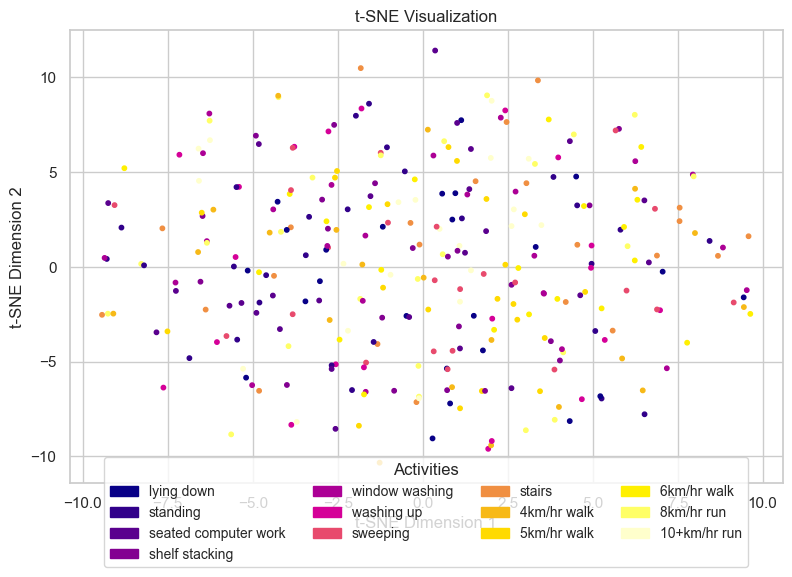

In [53]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

# Sample data (replace with your actual data and labels)
np.random.seed(42)
n_samples = 300
n_features = 20
n_classes = 13  # Corrected number of classes based on the image
data = np.random.rand(n_samples, n_features)
labels = np.random.randint(0, n_classes, n_samples)

# Define class names and corresponding colors (match the image)
class_names = [
    "lying down",
    "standing",
    "seated computer work",
    "shelf stacking",
    "window washing",
    "washing up",
    "sweeping",
    "stairs",
    "4km/hr walk",
    "5km/hr walk",
    "6km/hr walk",
    "8km/hr run",
    "10+km/hr run",
]
unique_labels = np.unique(labels)
if len(unique_labels) > len(class_names):
    raise ValueError("Number of unique labels exceeds the defined class names.")

# Assign specific colors to each class
color_map = {
    0: "#080087",  # lying down (dark blue)
    1: "#31008A",  # standing (medium blue)
    2: "#5A008E",  # seated computer work (light blue-purple)
    3: "#830091",  # shelf stacking (medium purple)
    4: "#AC0095",  # window washing (light purple-pink)
    5: "#D50098",  # washing up (pink)
    6: "#E84A6D",  # sweeping (light red-pink)
    7: "#F08F42",  # stairs (orange-red)
    8: "#F7B917",  # 4km/hr walk (light orange)
    9: "#FFDA00",  # 5km/hr walk (yellow-orange)
    10: "#FFF000", # 6km/hr walk (light yellow)
    11: "#FFFF66", # 8km/hr run (pale yellow)
    12: "#FFFFCC", # 10+km/hr run (very pale yellow)
}

# Ensure we only use colors for the existing labels
colors = [color_map[label] for label in labels]

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
reduced_data = tsne.fit_transform(data)

# Create the scatter plot
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=colors, s=10) # Use the assigned colors

# Create custom legend handles and labels
handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[i]) for i in sorted(color_map.keys()) if i in unique_labels]
labels_legend = [class_names[i] for i in sorted(color_map.keys()) if i in unique_labels]

print("Unique Labels:", np.unique(labels))
print("Color Map Keys:", color_map.keys())
print("Handles:", handles)
print("Labels:", labels_legend)

# Try adding the legend to the axes
legend = ax.legend(handles, labels_legend, loc="lower center", bbox_to_anchor=(0.5, -0.2), ncol=4, fontsize='small', title="Activities")
legend.get_title().set_fontsize('medium')

# Adjust layout to make space for the legend
plt.subplots_adjust(bottom=0.3)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust for title if needed

# Set plot title
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

# Show the plot
plt.show()